In [58]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn import image as nimg
from nilearn import plotting as nplot
%matplotlib inline

In [59]:
bids_dir = Path("/work/816119/InSpePosNegData/BIDS_2023E")
path_to_first_level = Path("/work/LauraBockPaulsen#1941/fMRI_analysis/flms")

In [60]:
subjects = ["0116"]#, "0117", "0118", "0119", "0120", "0121", "0122", "0123"]

for subject in subjects:
    # get subject flm 
    subject_flm = pickle.load(open(path_to_first_level / f"flm_{subject}.pkl", "rb"))

    # get subject bold for all runs
    subject_BOLD = []
    for run in [1, 2, 3, 4, 5, 6]:
        bold_path = bids_dir / "derivatives" / f"sub-{subject}" / "func" / f"sub-{subject}_task-boldinnerspeech_run-{run}_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

        subject_BOLD.append(bold_path)


# Parcel to get visual area voxels

In [62]:
# ensure that the atlas is downloaded
atlas_path = Path("../atlases")

if not atlas_path.exists():
    atlas_path.mkdir()

atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(atlas_path)

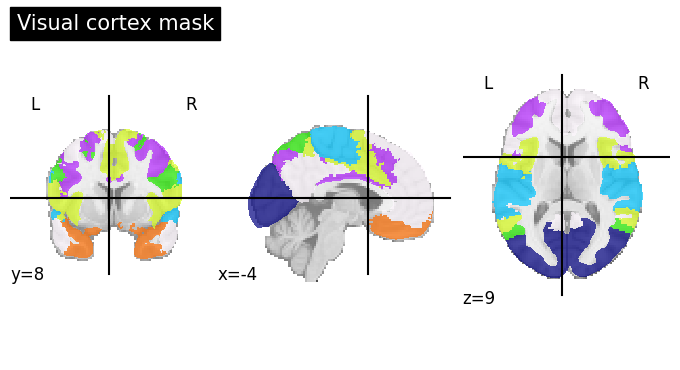

In [63]:

roi_labels = nimg.load_img(atlas_yeo_2011["thick_7"])
nplot.plot_roi(roi_labels, title="Visual cortex mask")

In [64]:
func_img = nib.load(subject_BOLD[0])

In [65]:
print('Size of functional image:', func_img.shape)
print('Size of atlas image:', roi_labels.shape)

# we have to resample
resampled_labels= nimg.resample_to_img(roi_labels, func_img, interpolation = 'nearest')
print('Size of resampled atlas image:', resampled_labels.shape)

Size of functional image: (78, 92, 78, 490)
Size of atlas image: (256, 256, 256, 1)
Size of resampled atlas image: (78, 92, 78, 1)


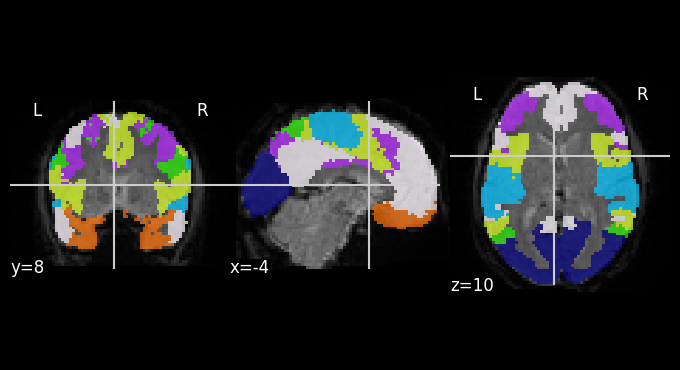

In [66]:
# plotting our parcels over the bold
nplot.plot_roi(resampled_labels, func_img.slicer[:, :, :, 54])

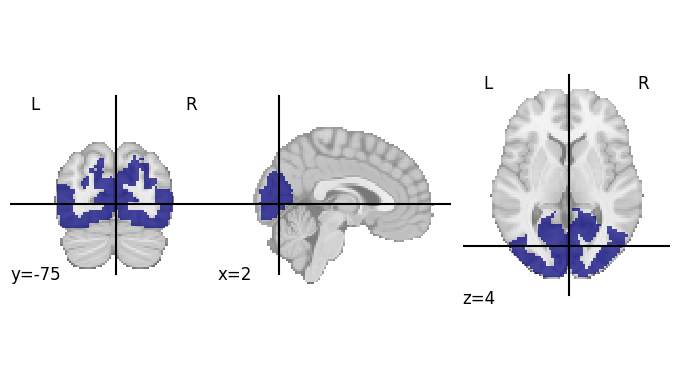

In [67]:
# Make a mask for ROI 1 (visual area)
roi_mask_visual = nimg.math_img('a == 1', a=resampled_labels)  

# Visualize ROI
nplot.plot_roi(roi_mask_visual)

(490, 11190)


/work/LauraBockPaulsen#1941/fMRI_analysis/env/lib/python3.10/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


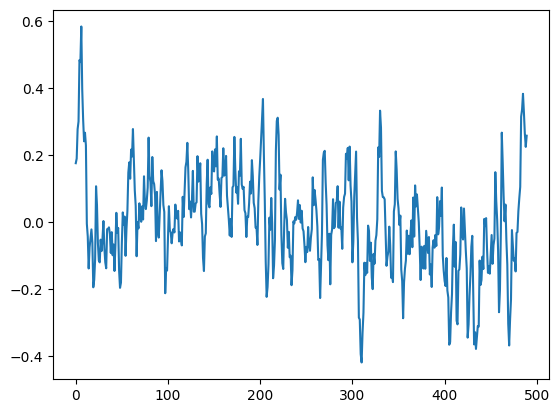

In [69]:
# apply the mask to the bold
from nilearn import input_data

masker = input_data.NiftiMasker(mask_img=roi_mask_visual, standardize=True)
masked_data = masker.fit_transform(func_img)

# average in visual cortex
visual_bold = np.mean(masked_data, axis=1)

In [ ]:
# plot the average time series with event markers
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(visual_bold, color='k', lw=2)

# add event markers
for event in subject_flm.events:
    ax.axvline(event, color='r', linestyle='--', lw=2)